In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### Here I am loading the data instead of computing again due to my computer's memory and processing constriants

## Loading the Image Vectors calculated from CNN

In [2]:
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')

## Loading the Preprocessed Apparel data

In [3]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
df_asins = list(data['asin'])
asins = list(asins)

In [4]:
print(asins[:5])
print('='*20)
print(df_asins[:5])

['0000000060', '6042589113', '6342521018', 'B00029I0Z6', 'B0006LTFTK']
['B004GSI2OS', 'B012YX2ZPI', 'B003BSRPB0', 'B014ICEJ1Q', 'B01NACPBG2']


**The indices of `bottleneck_features_train` are not in right order. So, we have to order them. Or this will be problem when we calculate pairwise distances using the inbuilt function and add the weighted sum to our total pairwise distances.**

In [5]:
ordered_indices = sorted(range(len(asins)), key=lambda x: df_asins.index(asins[x]))
np.array(asins)[ordered_indices[:5]]

array(['B004GSI2OS', 'B012YX2ZPI', 'B003BSRPB0', 'B014ICEJ1Q',
       'B01NACPBG2'], dtype='<U10')

In [6]:
ordered_image_vect = bottleneck_features_train[ordered_indices]

In [7]:
print(ordered_image_vect.shape)

(16042, 25088)


## One hot encoding for `brand`, `product_type`, `color` columns

In [8]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

## Idf weighted Word2Vec for `title` column.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(data['title'])
print(len(tfidf_model.get_feature_names()))
print(tfidf_model.idf_.shape)
word_idfs = dict(zip(tfidf_model.get_feature_names(), tfidf_model.idf_))
print(len(word_idfs))

12609
(12609,)
12609


In [11]:
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [12]:
from tqdm import tqdm

idf_w2v_titles = []

for title in tqdm(data['title']):
    sent_vect = np.zeros(300)
    idf_sum = 0
    for word in title.split():
        if word in model.keys() and word in word_idfs.keys():
            sent_vect += (model[word] * word_idfs[word])
            idf_sum += word_idfs[word]
    if idf_sum != 0:
        sent_vect /= idf_sum
    idf_w2v_titles.append(sent_vect)

idf_w2v_titles = np.array(idf_w2v_titles)
print(idf_w2v_titles.shape)

100%|█████████████████████████████████████████████████████████████████████████| 16042/16042 [00:01<00:00, 13315.39it/s]


(16042, 300)


In [14]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [75]:
def display_img(url):
    # we get the url of the apparel and download it
#     response = requests.get(url)
#     img = Image.open(BytesIO(response.content))
    img = Image(url=url, embed=True)
    # we will display it in notebook 
    display(img)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_words = [word for word in sentance1.split() if word in model.keys() and word in word_idfs.keys()]
    s1_vec = [(model[word] * word_idfs[word]) for word in s1_words]
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_words = [word for word in sentance2.split() if word in model.keys() and word in word_idfs.keys()]
    s2_vec = [(model[word] * word_idfs[word]) for word in s2_words]
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
#     gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
#     ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,3), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(s2_words)
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(s1_words)
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    plt.show()
    # in last 25 * 10:15 grids we display image
#     ax2 = plt.subplot(gs[:, 10:16])
#     # we dont display grid lins and axis labels to images
#     ax2.grid(False)
#     ax2.set_xticks([])
#     ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url)

In [76]:
def idf_w2v_brand(doc_id, w1, w2, w3, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(idf_w2v_titles, idf_w2v_titles[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    image_dist = pairwise_distances(ordered_image_vect, ordered_image_vect[doc_id].reshape(1,-1))
    
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * image_dist)/float(w1 + w2 + w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
#         display(Image(url=data['medium_image_url'].loc[df_indices[i]], embed=True))
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i])
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from total data (including image) :', pdists[i])
        print('='*125)

**Let us give equal weight to title, extra features and image features and see our results first.**

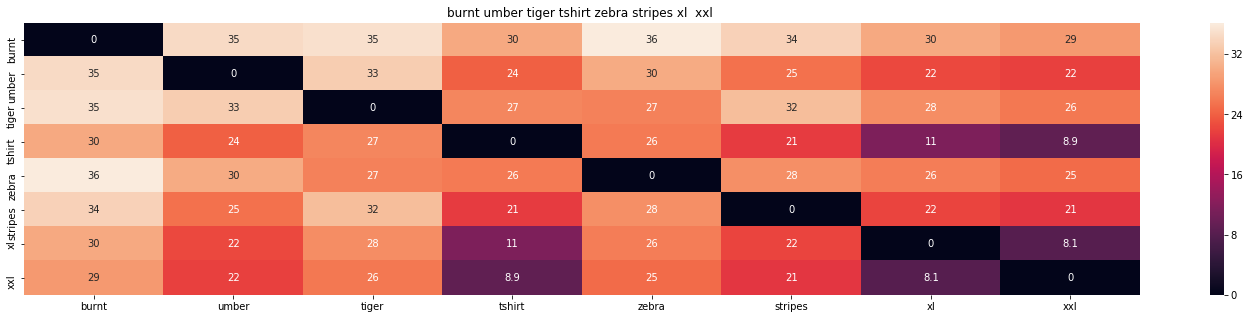

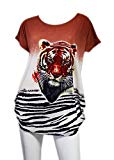

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from total data (including image) : 1.4216537238098681e-06


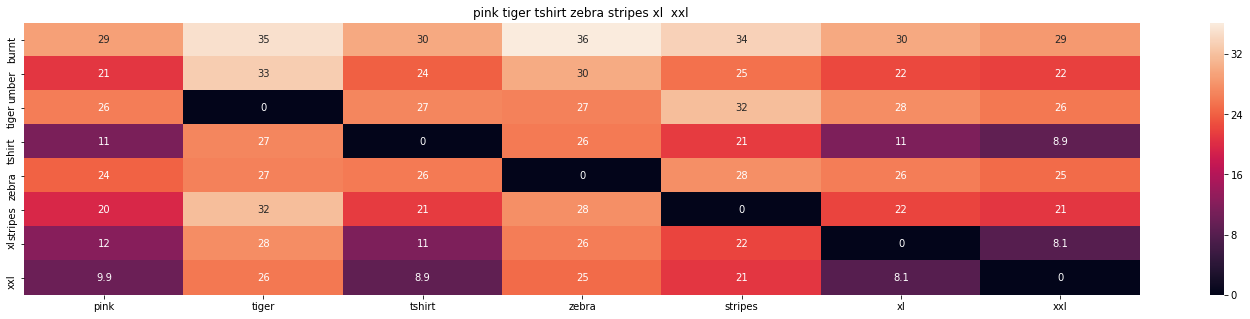

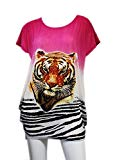

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from total data (including image) : 10.747429163661844


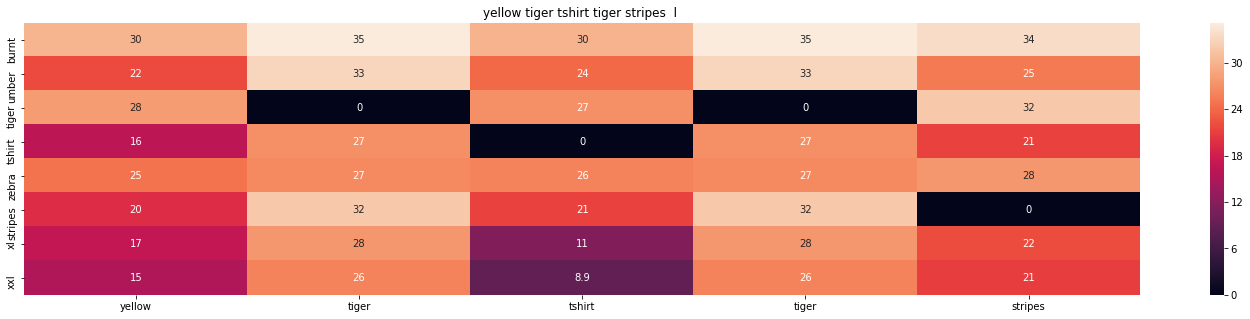

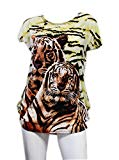

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from total data (including image) : 14.664675581507474


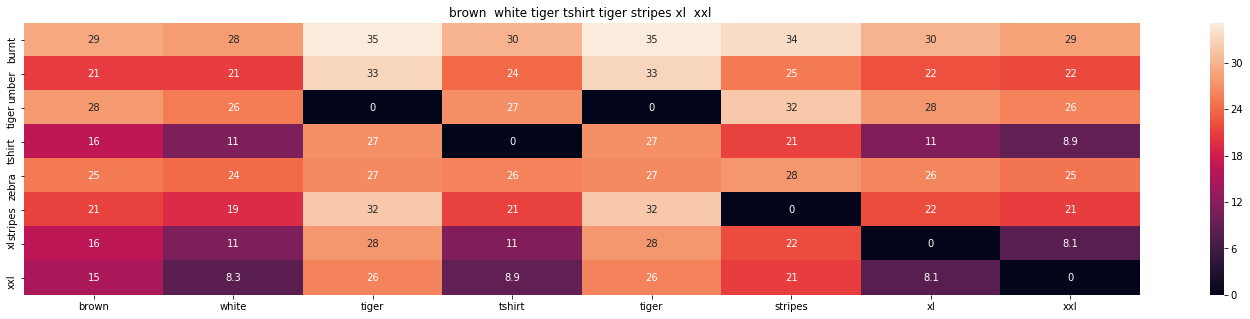

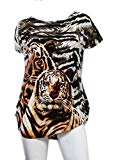

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from total data (including image) : 14.972075478957672


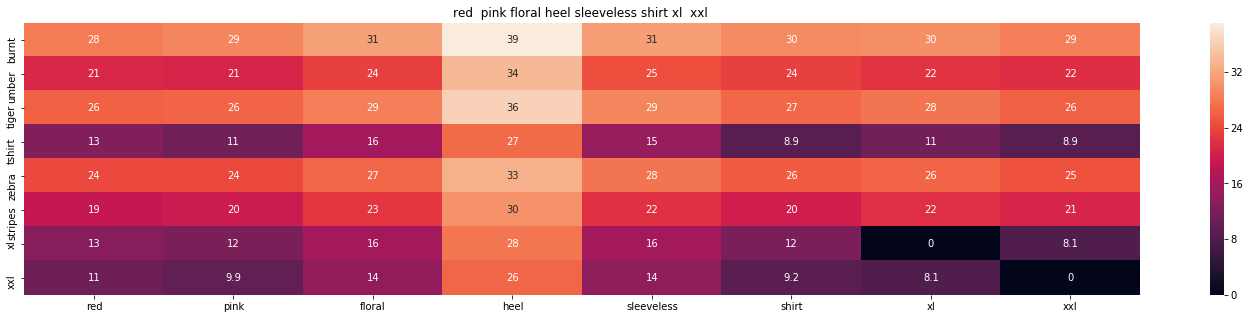

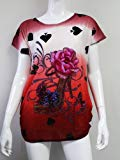

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from total data (including image) : 17.035315252858016


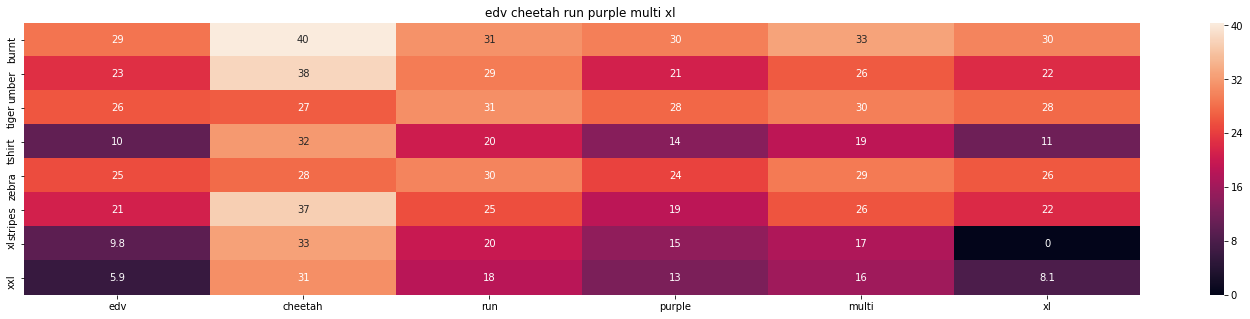

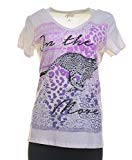

ASIN : B01CUPYBM0
Brand : Styleco
euclidean distance from total data (including image) : 17.354493654190243


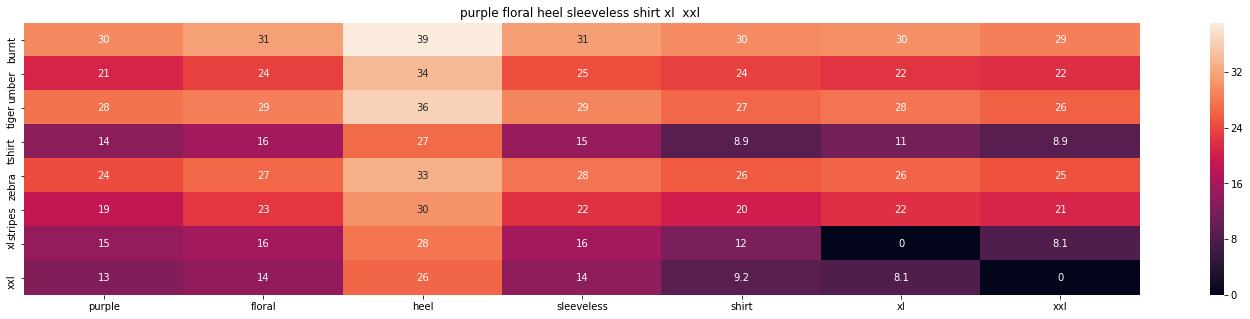

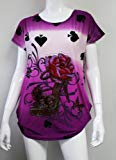

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from total data (including image) : 17.360399161602984


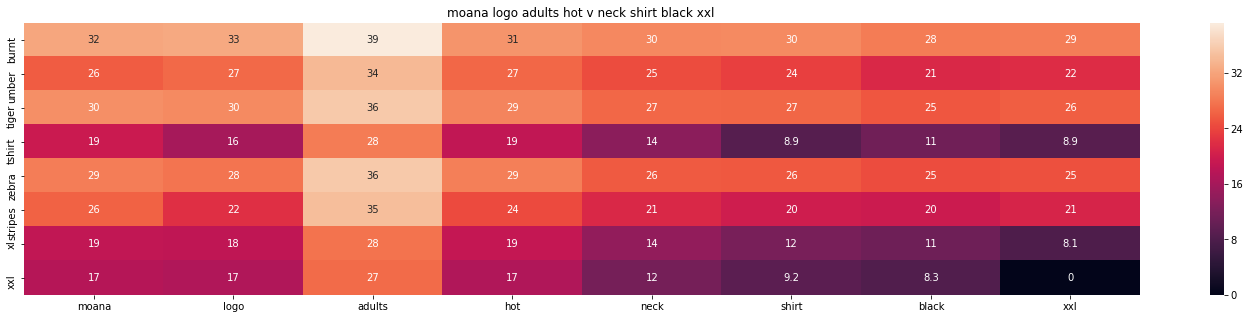

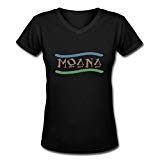

ASIN : B01LX6H43D
Brand : BOBOB
euclidean distance from total data (including image) : 17.418471723870393


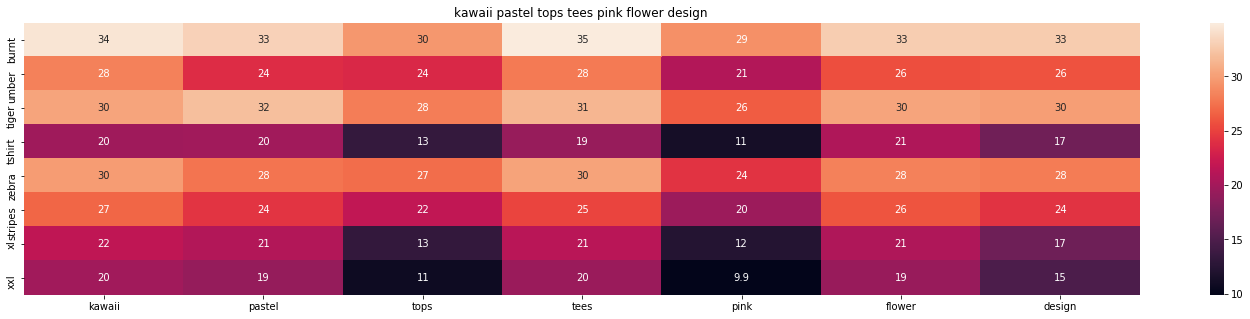

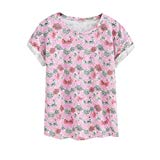

ASIN : B071FCWD97
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 17.425361012427164


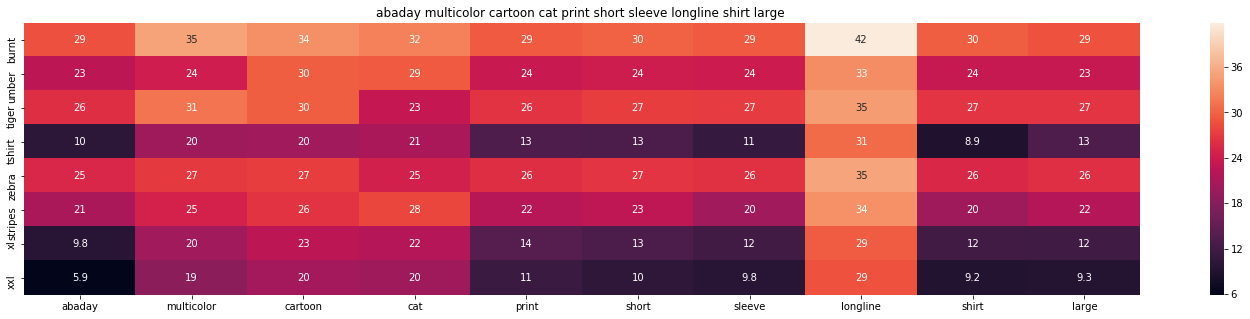

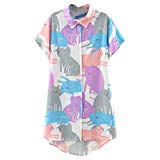

ASIN : B01CR57YY0
Brand : ABADAY
euclidean distance from total data (including image) : 17.430129060318404


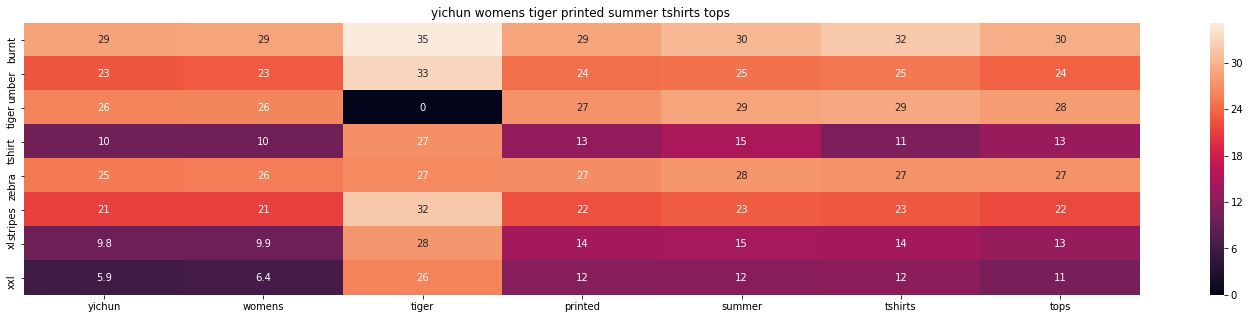

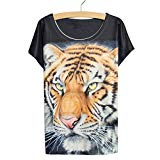

ASIN : B010NN9RXO
Brand : YICHUN
euclidean distance from total data (including image) : 17.44386532744975


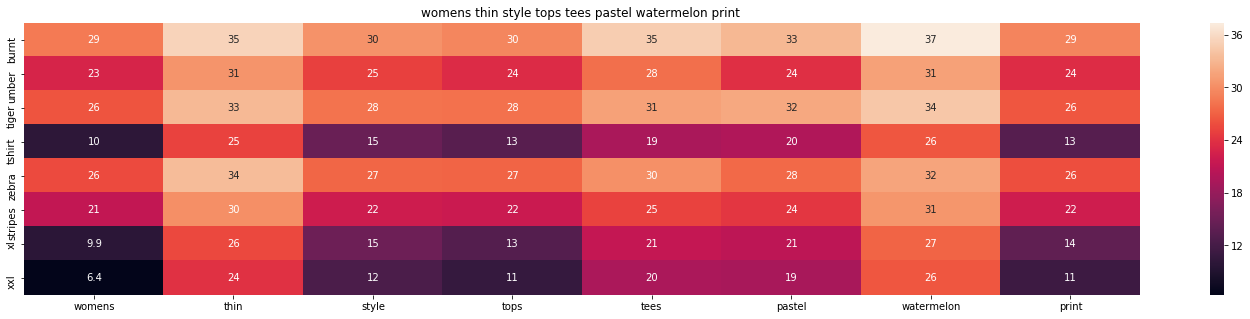

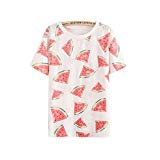

ASIN : B01JUNHBRM
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 17.47822748164476


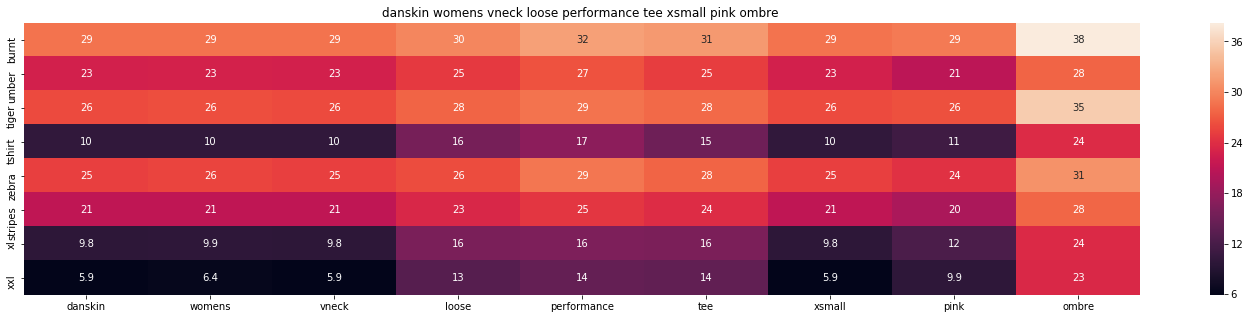

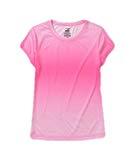

ASIN : B01F7PHXY8
Brand : Danskin Now
euclidean distance from total data (including image) : 17.51399213379263


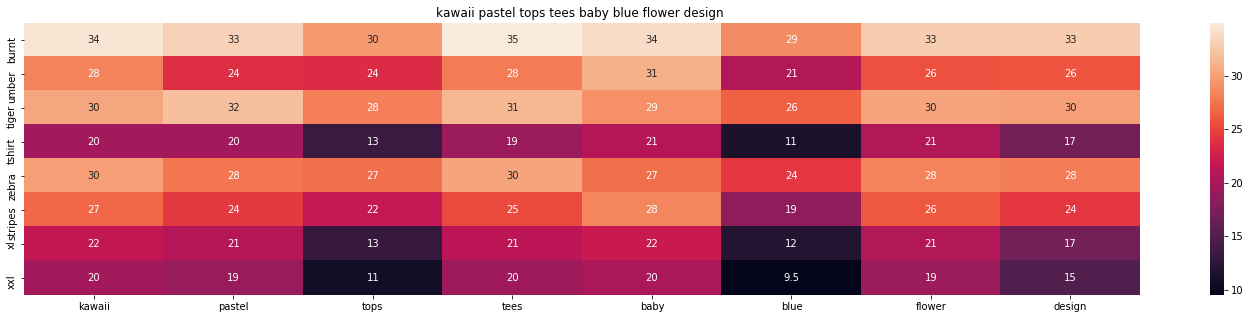

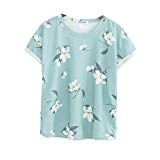

ASIN : B071SBCY9W
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 17.567494069971524


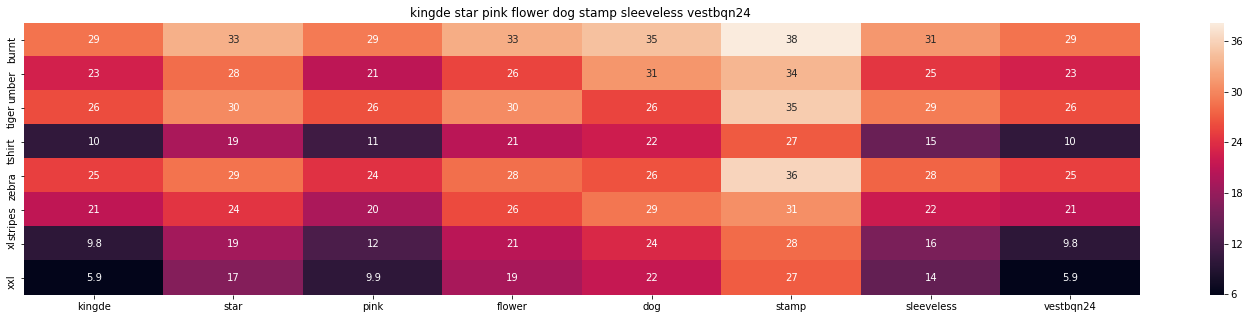

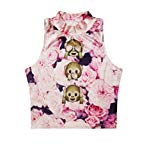

ASIN : B015H3W9BM
Brand : KINGDE
euclidean distance from total data (including image) : 17.583547871985036


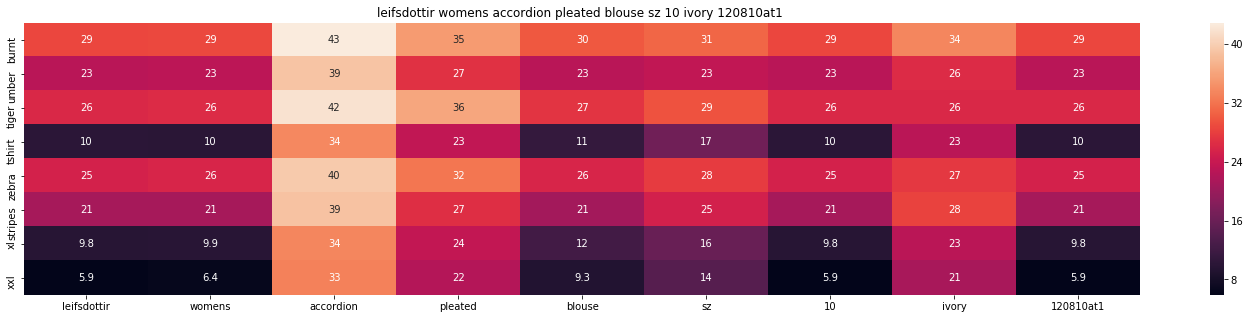

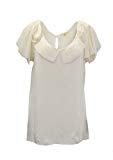

ASIN : B01B6E0DX2
Brand : Leifsdottir
euclidean distance from total data (including image) : 17.58946914406769


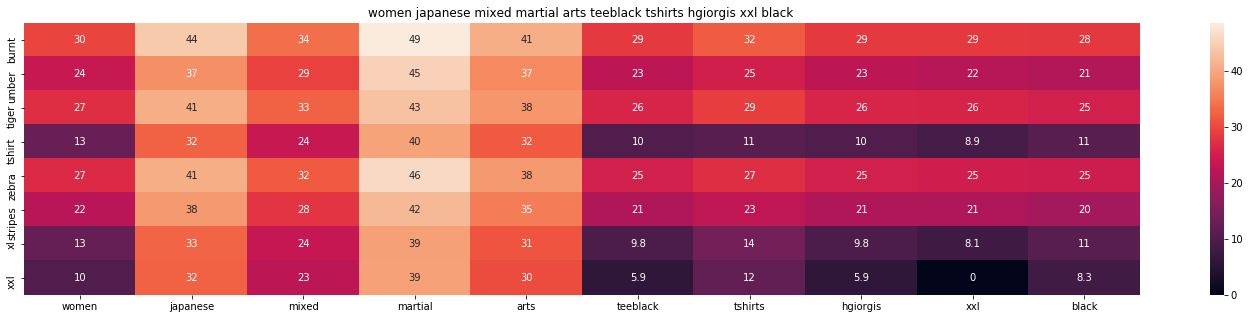

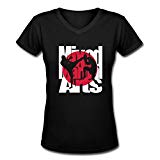

ASIN : B01JQ096HW
Brand : Constanza
euclidean distance from total data (including image) : 17.61472419434818


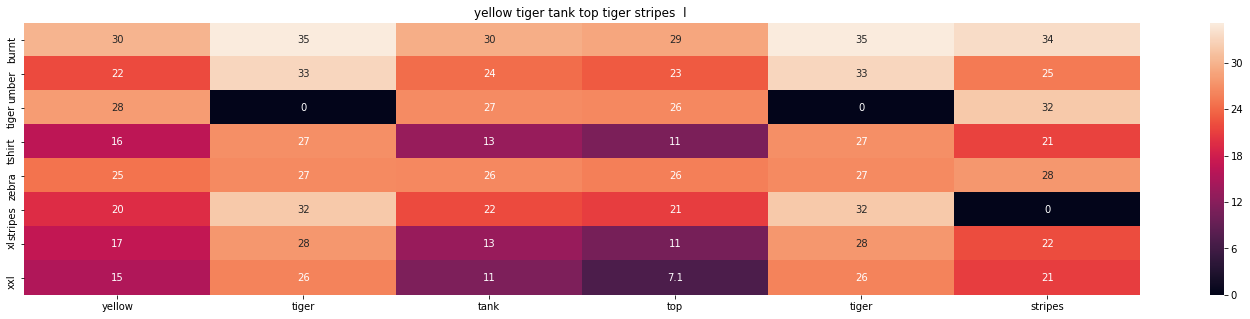

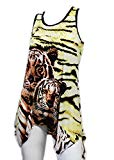

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from total data (including image) : 17.63771451979729


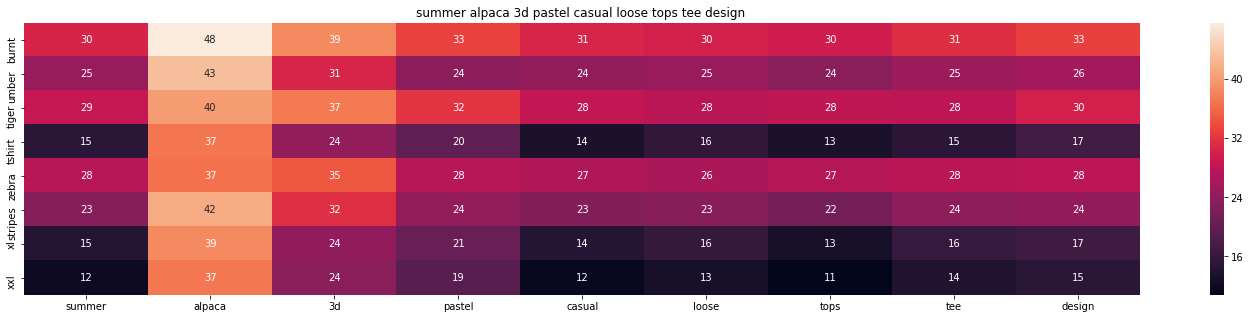

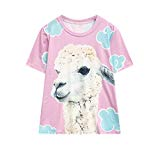

ASIN : B01I80A93G
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 17.64385550266359


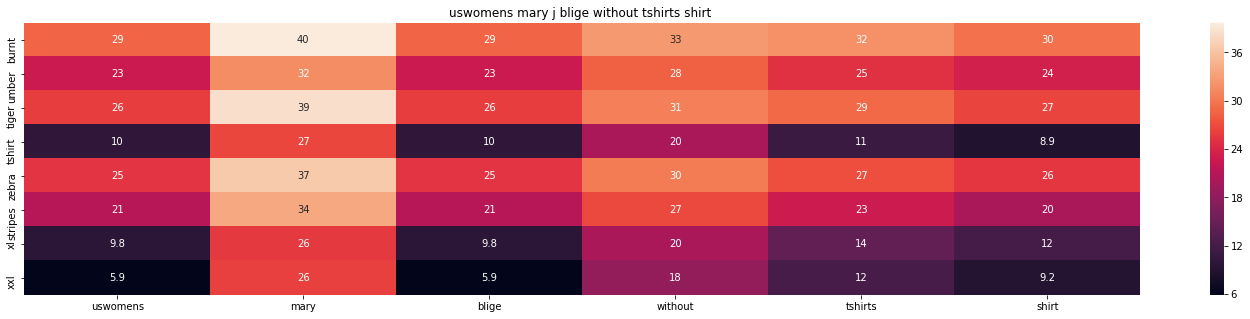

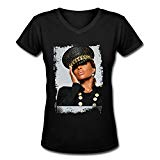

ASIN : B01M0XXFKK
Brand : South Dakota A.
euclidean distance from total data (including image) : 17.661228759041066


In [77]:
# arguments for idf_w2v_brand function are row_number, title_weight, extra_feats_weight, image_feats_weight, number_of_results
idf_w2v_brand(12566, 5, 5, 5, 20)

**From above result we can see some new shirts that appeared which are not there in previous models (like MOANA shirt). This might be due to image of the shirt as the shape of the shirt is similar but I am not quite sure why the mdoel picked those shirts.**

**Now we try giving extra features more weight (5 times than other features) and see the results.**

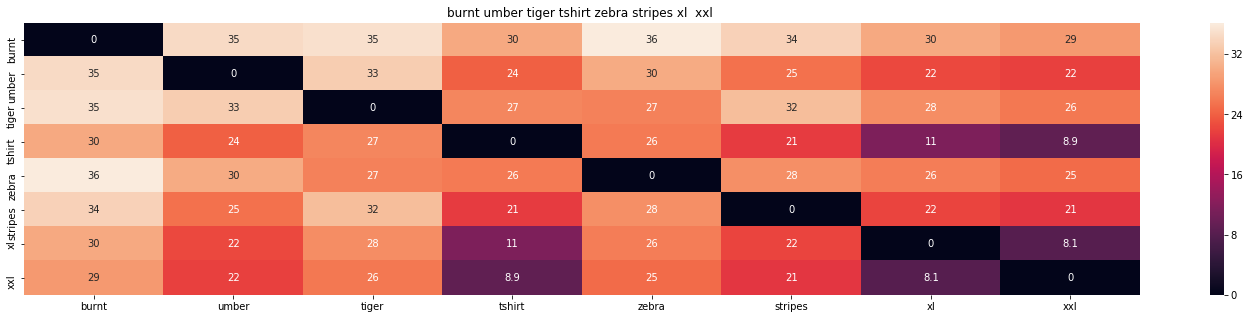

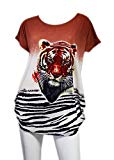

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from total data (including image) : 6.092801673470863e-07


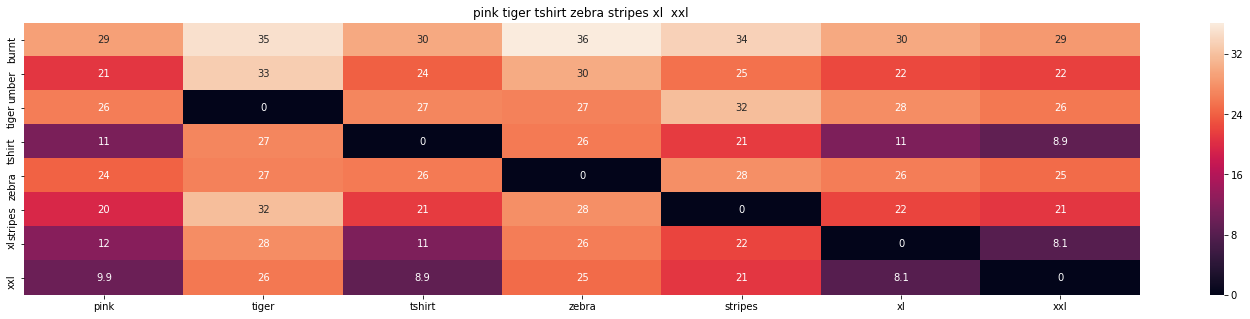

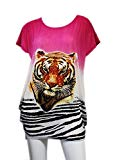

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from total data (including image) : 5.414163105782559


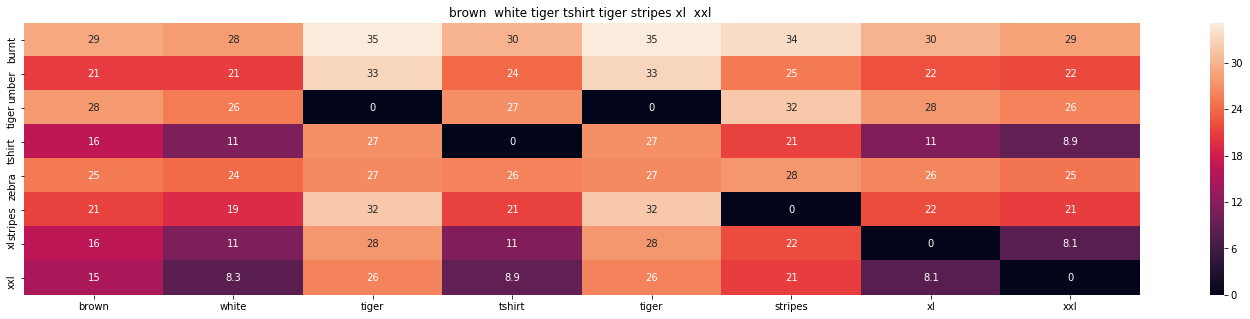

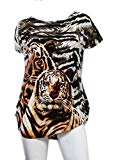

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from total data (including image) : 6.416603776696145


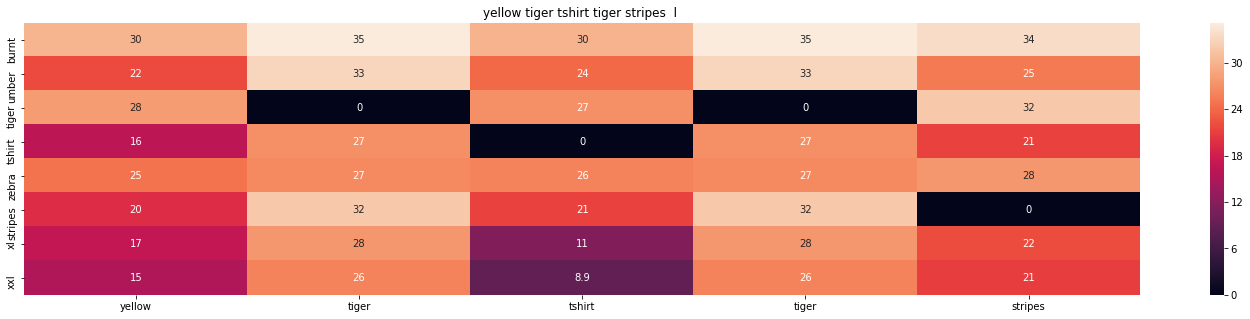

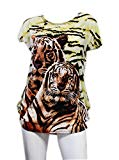

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from total data (including image) : 7.092982999144971


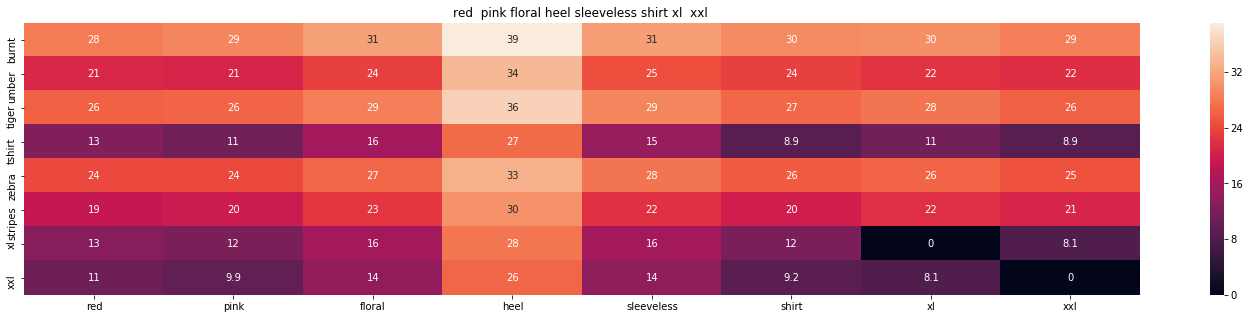

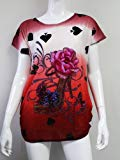

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from total data (including image) : 8.108971429723777


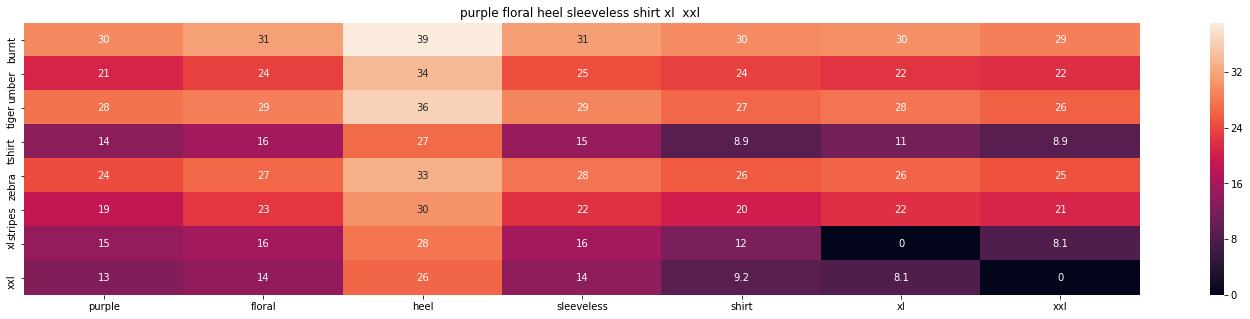

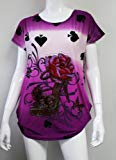

ASIN : B00JV63VC8
Brand : Si Row
euclidean distance from total data (including image) : 8.24829310490019


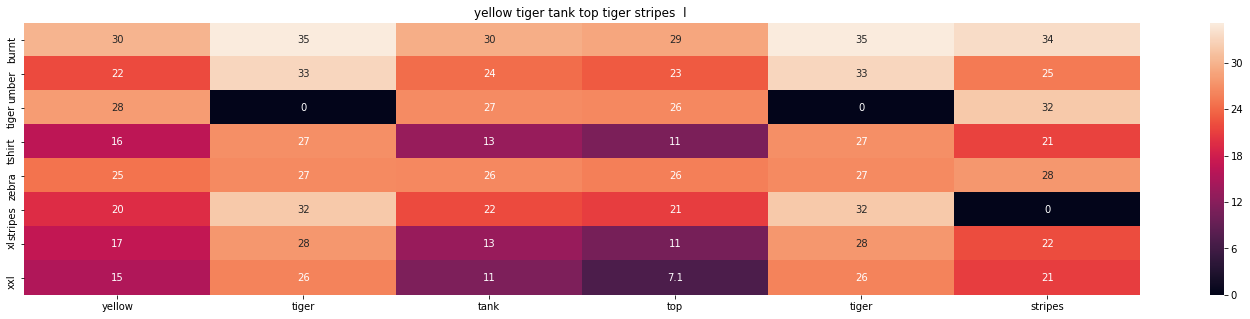

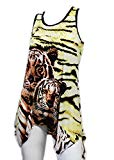

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from total data (including image) : 8.367142544126322


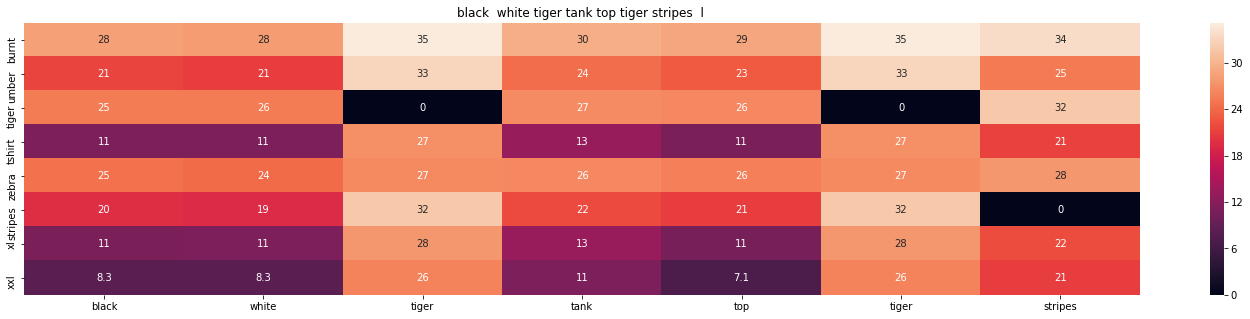

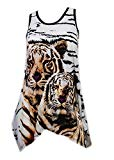

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from total data (including image) : 8.383451211390259


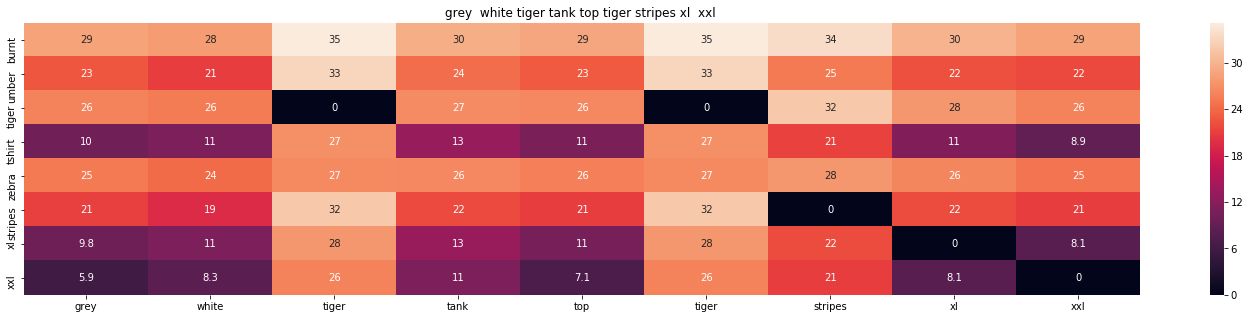

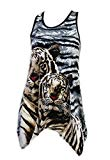

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from total data (including image) : 8.444773165977129


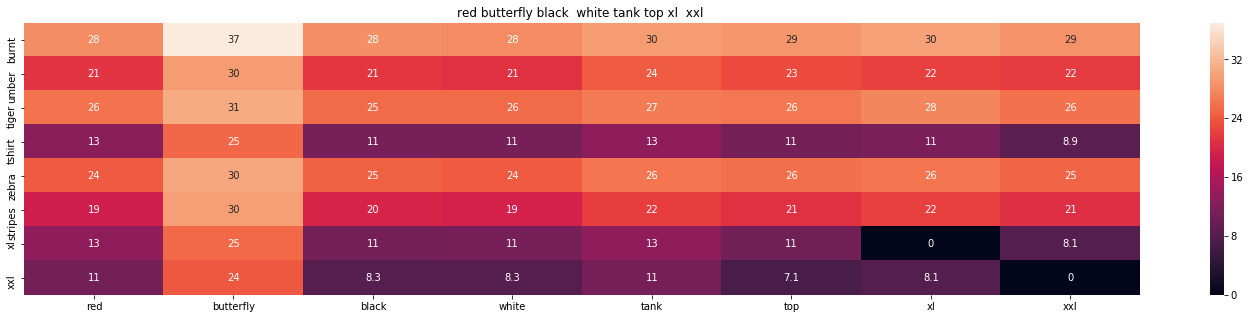

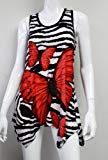

ASIN : B00JV63CW2
Brand : Si Row
euclidean distance from total data (including image) : 8.505606095943415


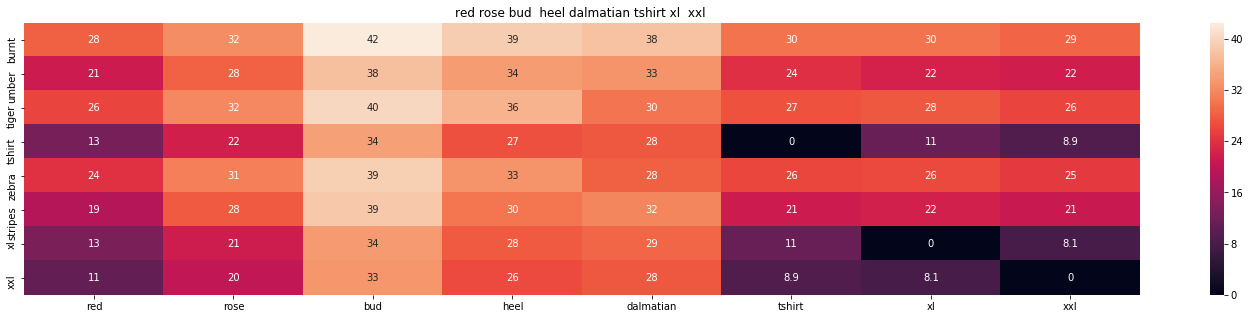

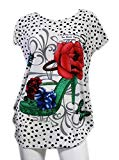

ASIN : B00JXQABB0
Brand : Si Row
euclidean distance from total data (including image) : 8.536867653352724


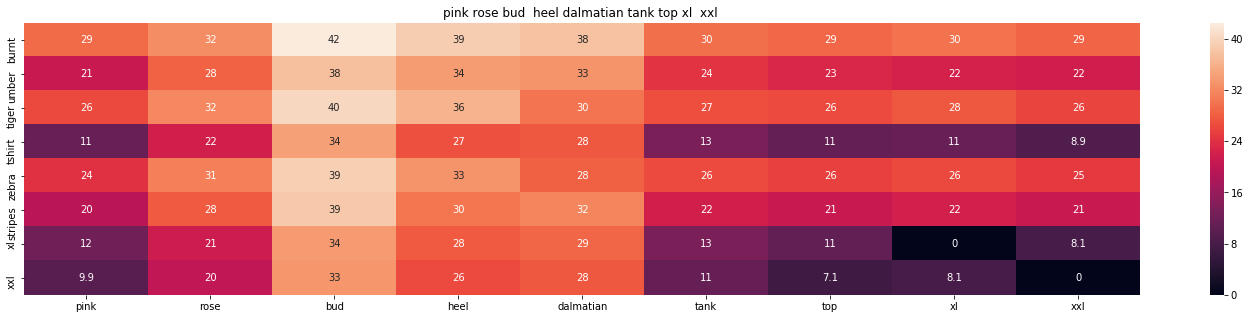

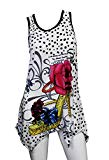

ASIN : B00JXQAX2C
Brand : Si Row
euclidean distance from total data (including image) : 8.538338808806833


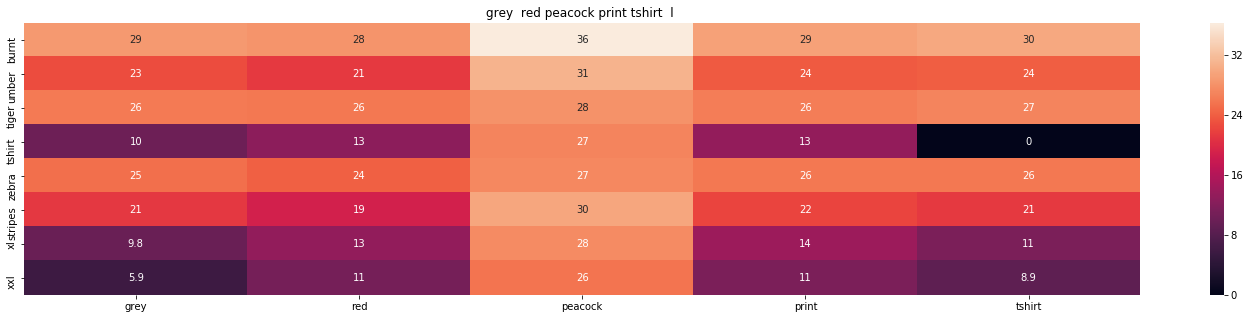

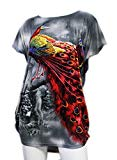

ASIN : B00JXQCFRS
Brand : Si Row
euclidean distance from total data (including image) : 8.766389416144886


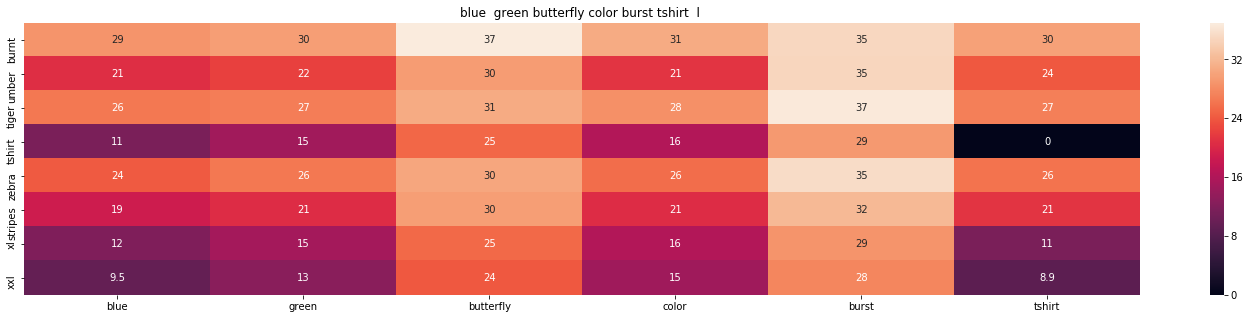

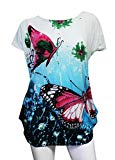

ASIN : B00JXQC0C8
Brand : Si Row
euclidean distance from total data (including image) : 8.778242366258077


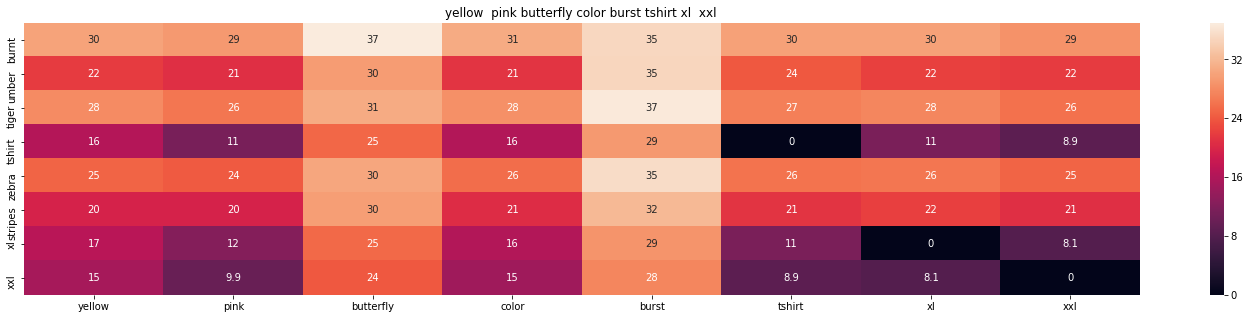

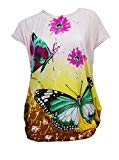

ASIN : B00JXQBBMI
Brand : Si Row
euclidean distance from total data (including image) : 8.832777899079192


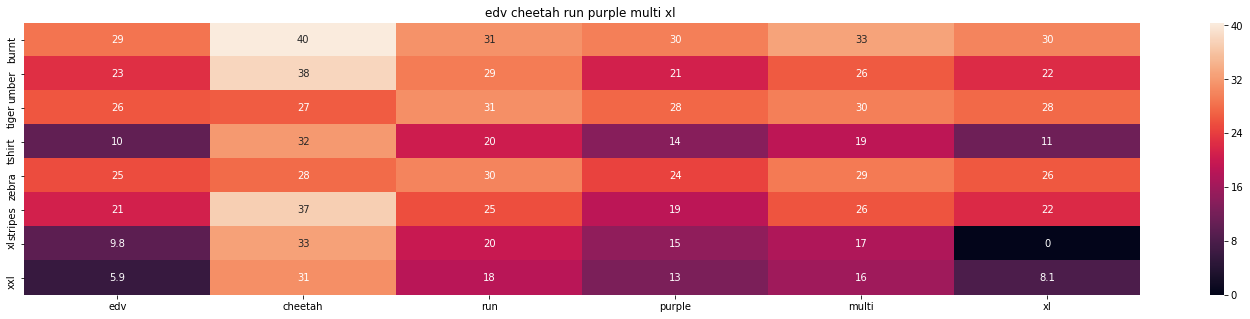

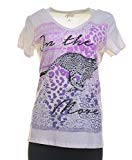

ASIN : B01CUPYBM0
Brand : Styleco
euclidean distance from total data (including image) : 8.949498029547014


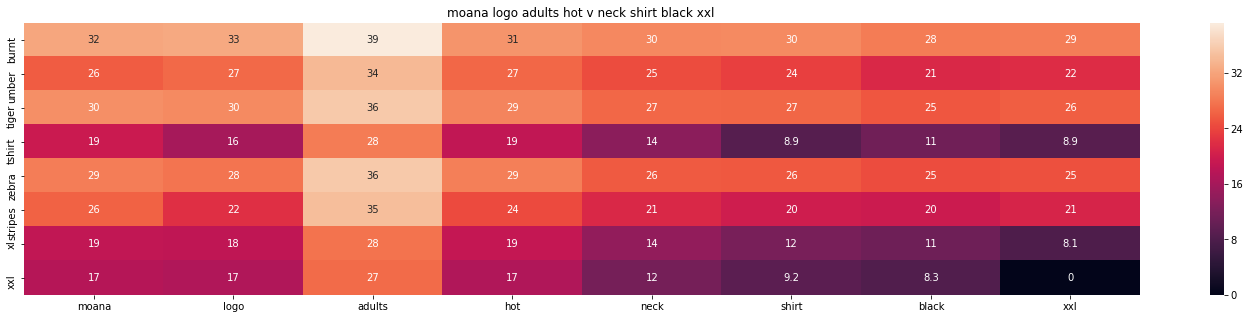

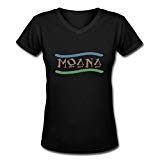

ASIN : B01LX6H43D
Brand : BOBOB
euclidean distance from total data (including image) : 8.976917202267078


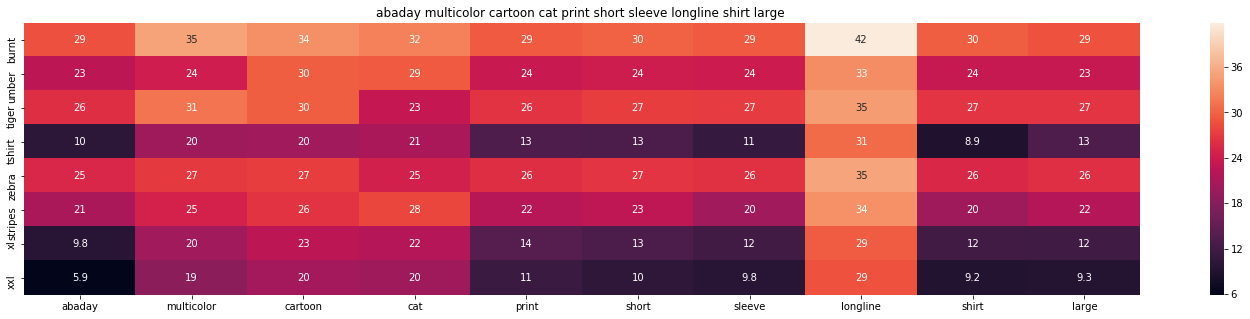

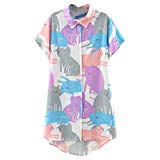

ASIN : B01CR57YY0
Brand : ABADAY
euclidean distance from total data (including image) : 8.98191320360194


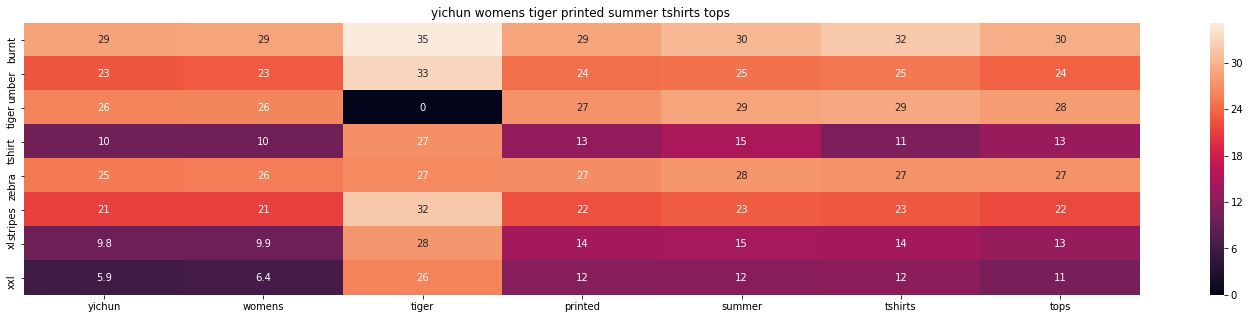

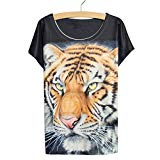

ASIN : B010NN9RXO
Brand : YICHUN
euclidean distance from total data (including image) : 8.987800175229658


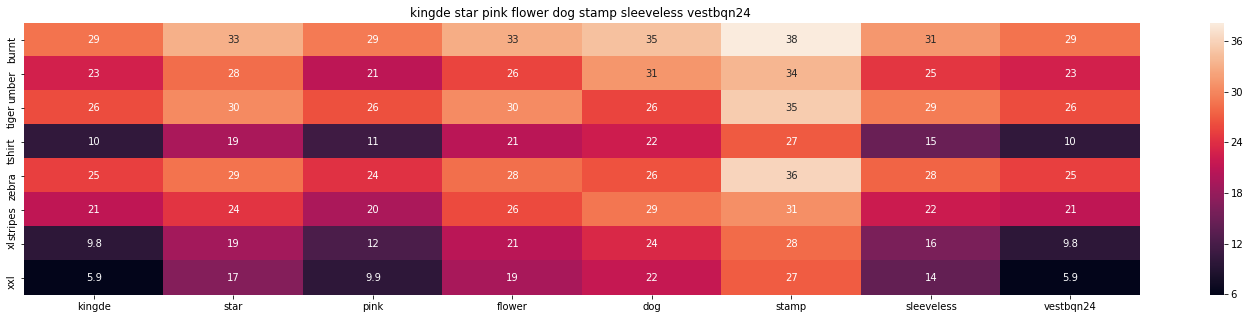

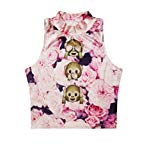

ASIN : B015H3W9BM
Brand : KINGDE
euclidean distance from total data (including image) : 9.047664122887639


In [78]:
idf_w2v_brand(12566, 5, 25, 5, 20)

**We can see that most of them are of same brand (which we already saw in previous models) and some shirts appeared even if they dont have same extra featured which might be due to high co-relation between images and title.**

**Now we try giving image features more weight (5 times than other features) and see the results.**

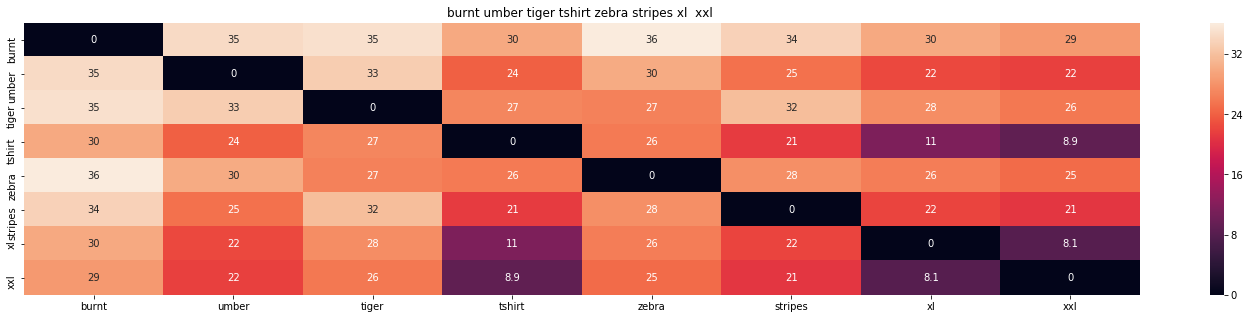

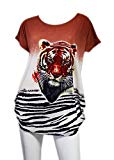

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from total data (including image) : 3.0464008367354315e-06


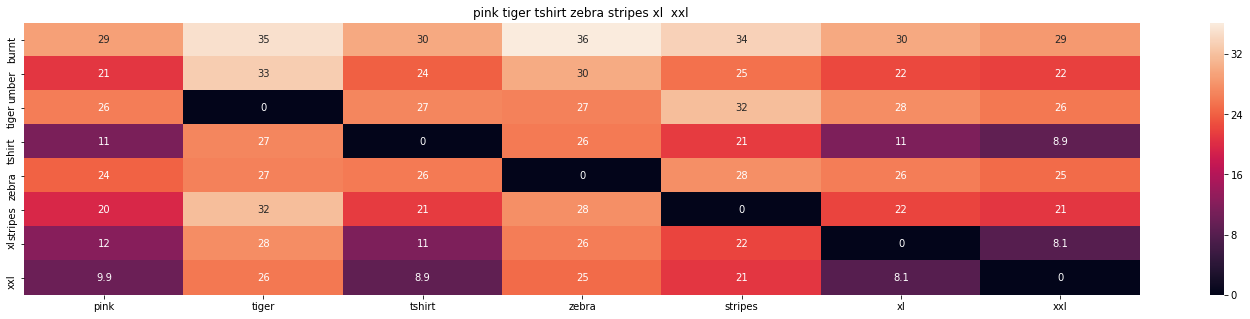

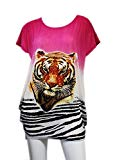

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from total data (including image) : 21.777567297819363


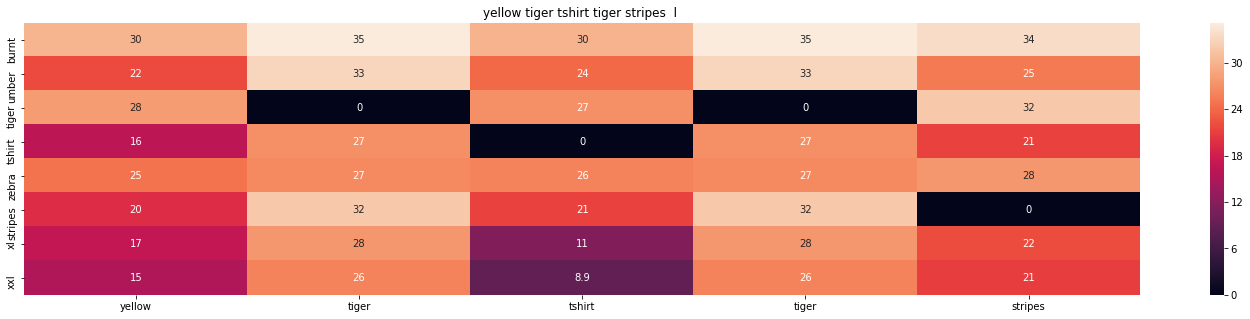

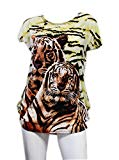

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from total data (including image) : 29.862643294697396


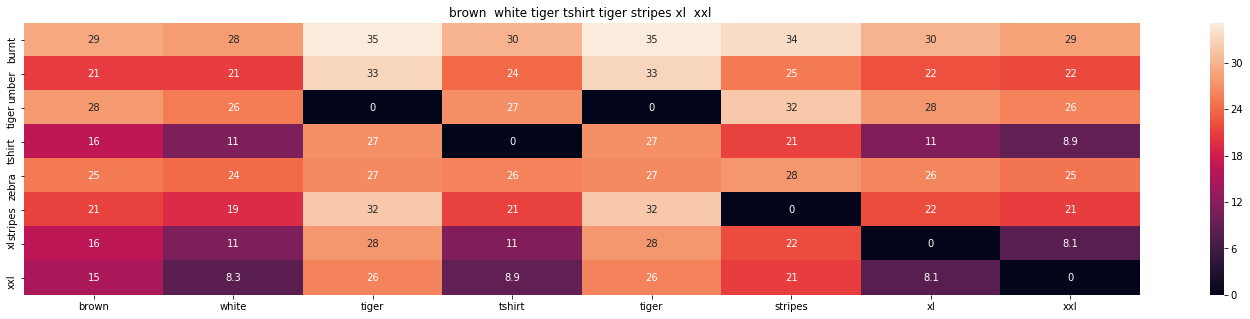

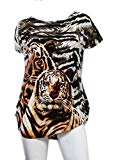

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from total data (including image) : 31.559550292460653


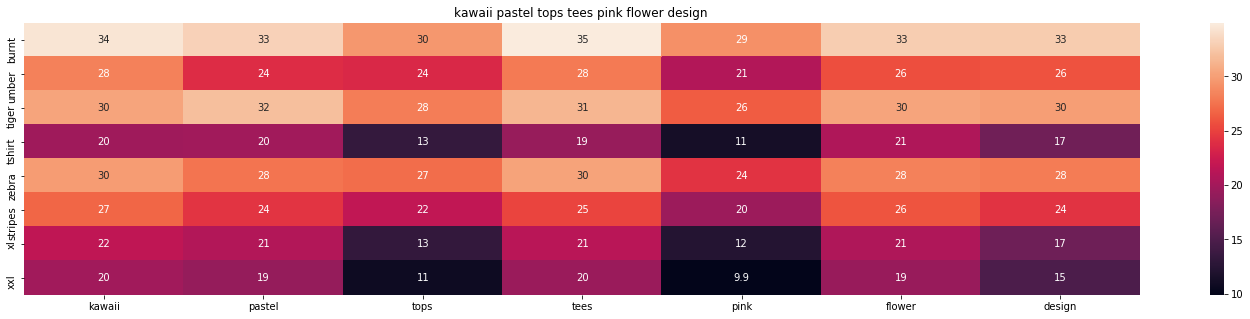

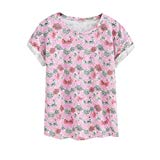

ASIN : B071FCWD97
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 34.54371507466186


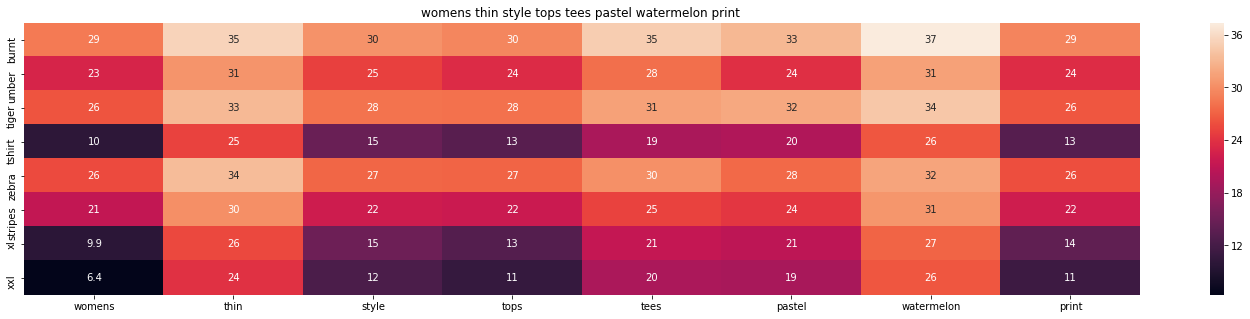

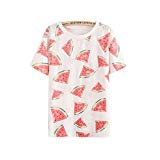

ASIN : B01JUNHBRM
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 34.75833641861227


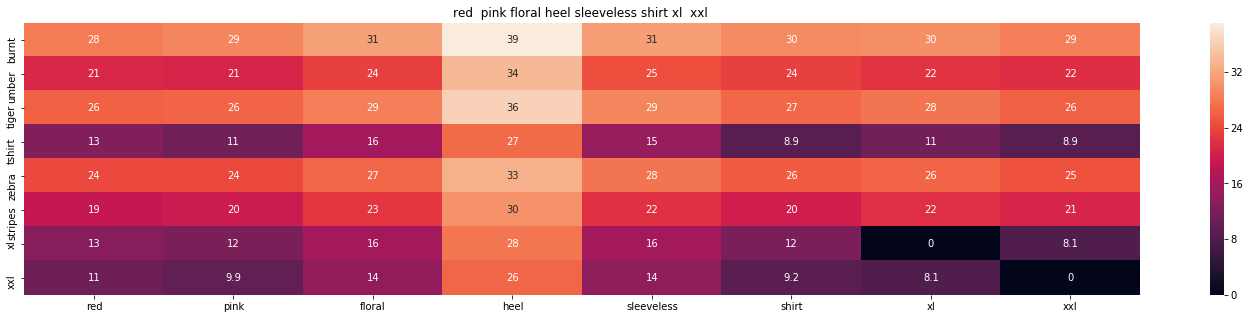

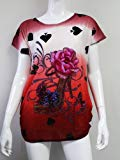

ASIN : B00JV63QQE
Brand : Si Row
euclidean distance from total data (including image) : 34.82624830242464


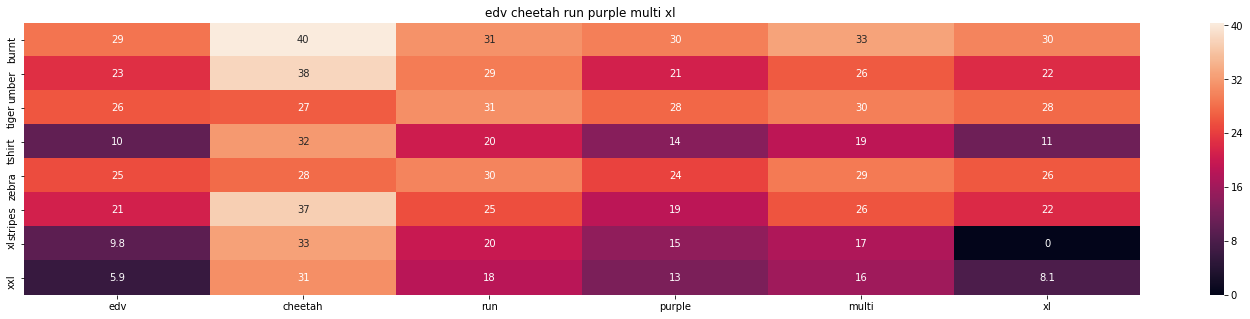

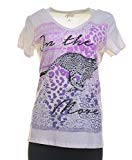

ASIN : B01CUPYBM0
Brand : Styleco
euclidean distance from total data (including image) : 34.89277450204693


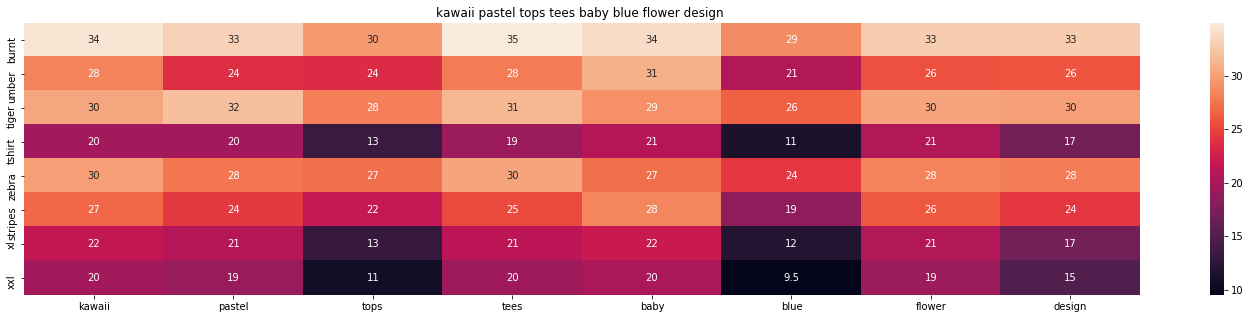

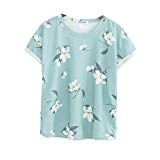

ASIN : B071SBCY9W
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 34.90153170800119


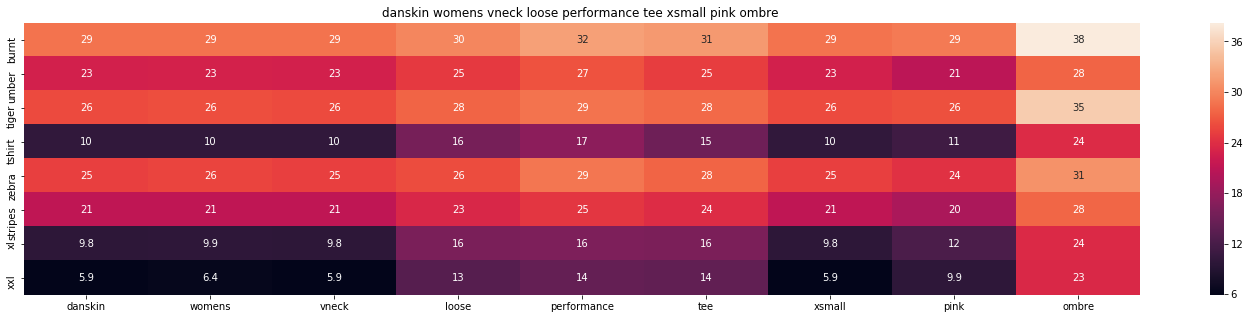

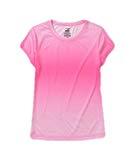

ASIN : B01F7PHXY8
Brand : Danskin Now
euclidean distance from total data (including image) : 34.992759847239256


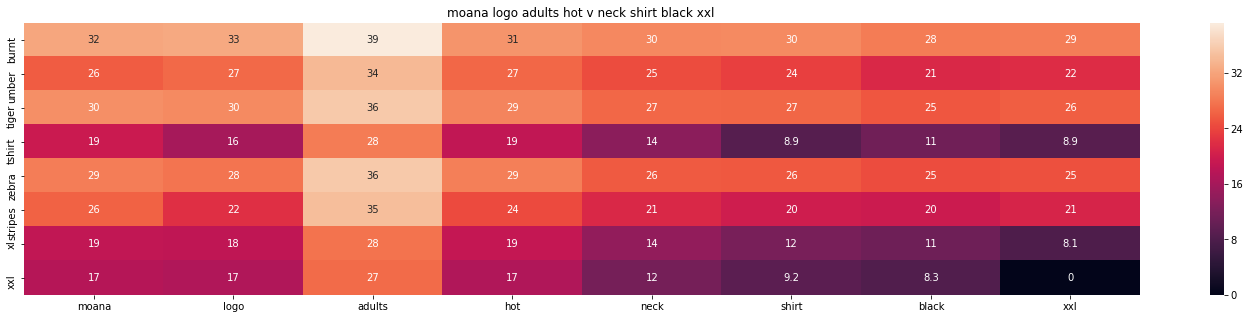

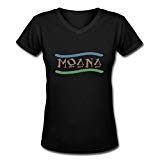

ASIN : B01LX6H43D
Brand : BOBOB
euclidean distance from total data (including image) : 35.04036622987303


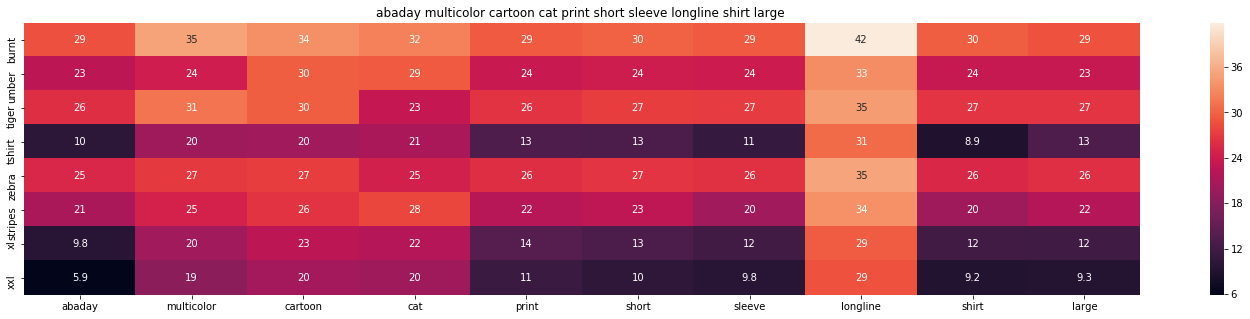

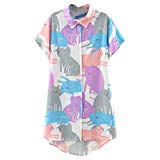

ASIN : B01CR57YY0
Brand : ABADAY
euclidean distance from total data (including image) : 35.05044558779271


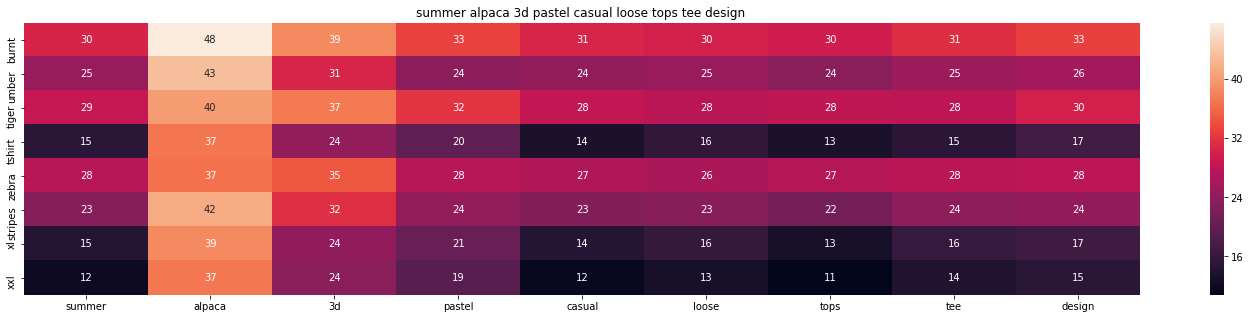

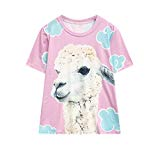

ASIN : B01I80A93G
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 35.058148068384845


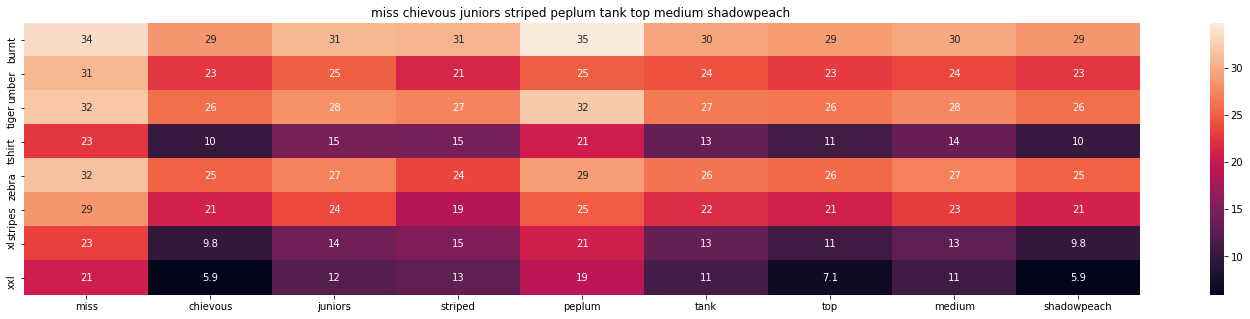

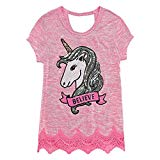

ASIN : B0177DM70S
Brand : MISS CHIEVOUS/AROUND THE WORLD APP
euclidean distance from total data (including image) : 35.08496467788137


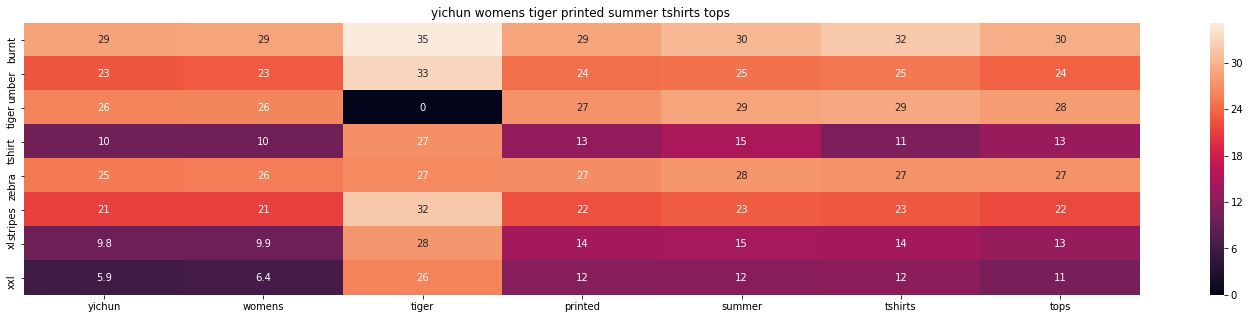

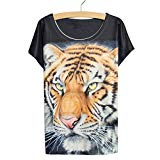

ASIN : B010NN9RXO
Brand : YICHUN
euclidean distance from total data (including image) : 35.16128817814253


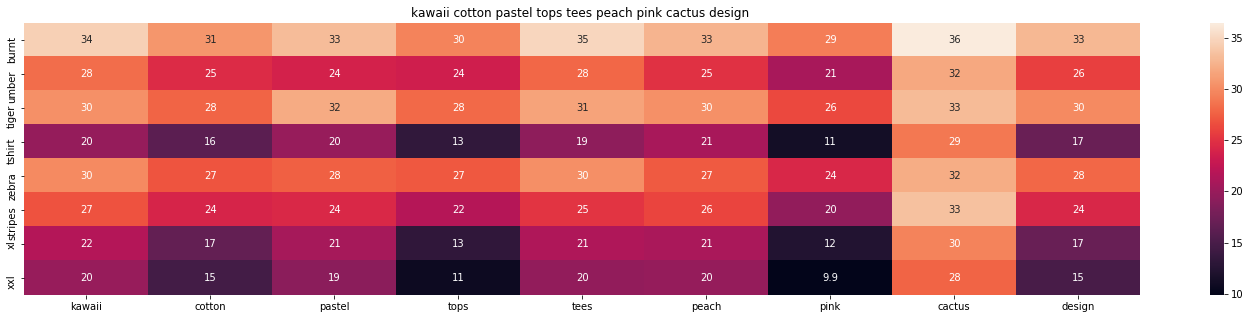

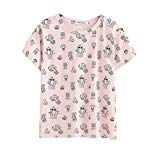

ASIN : B071WYLBZS
Brand : Namnoi Clothing Store
euclidean distance from total data (including image) : 35.22567998799676


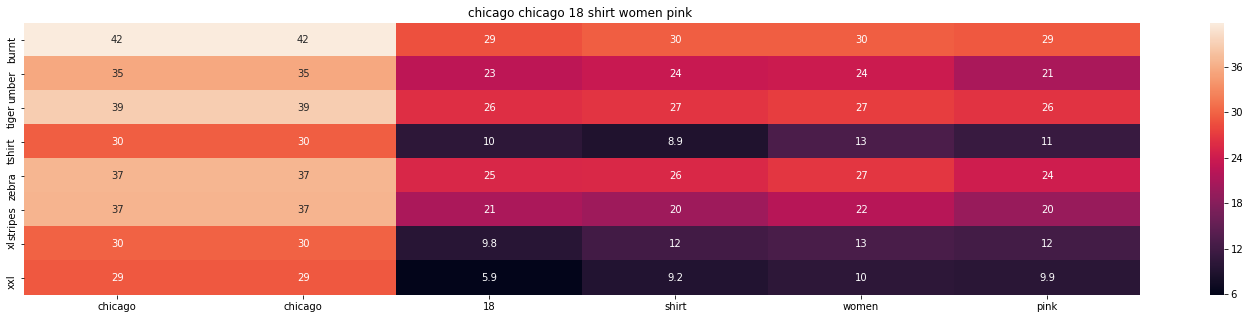

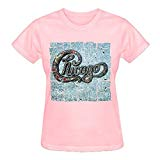

ASIN : B01GXAZTRY
Brand : Tony Arden
euclidean distance from total data (including image) : 35.25919432917166


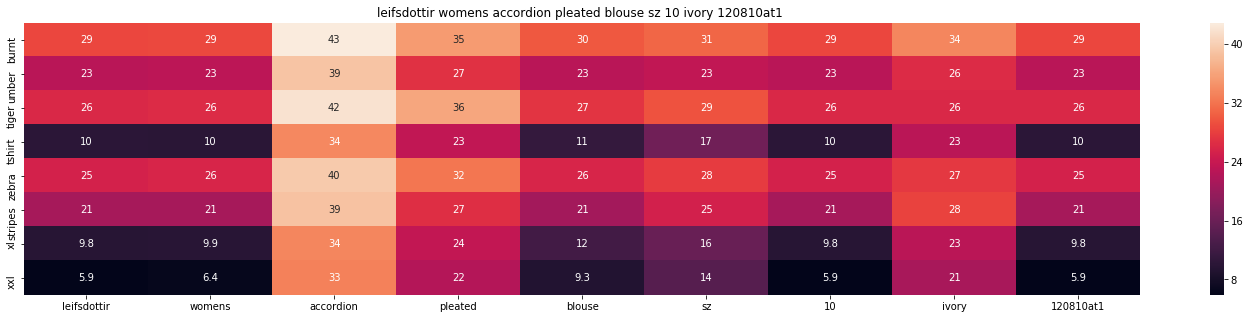

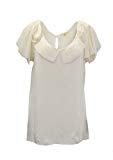

ASIN : B01B6E0DX2
Brand : Leifsdottir
euclidean distance from total data (including image) : 35.323003604293525


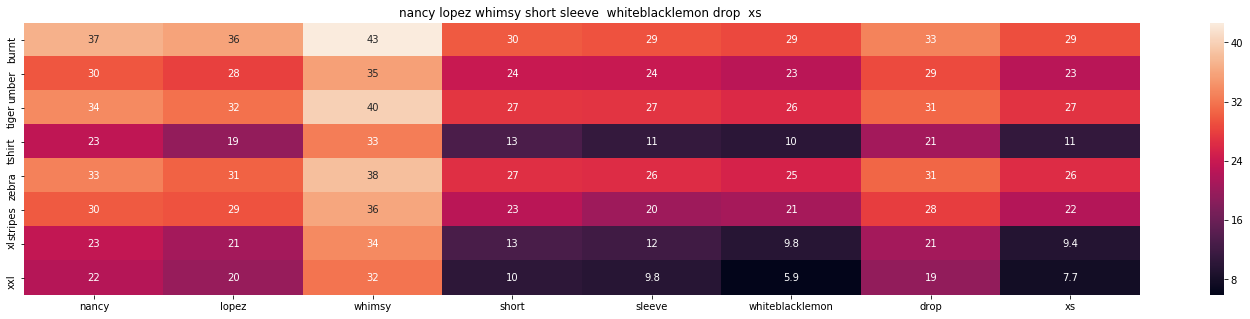

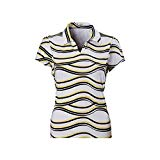

ASIN : B01MPX6IDX
Brand : Nancy Lopez
euclidean distance from total data (including image) : 35.32758761946154


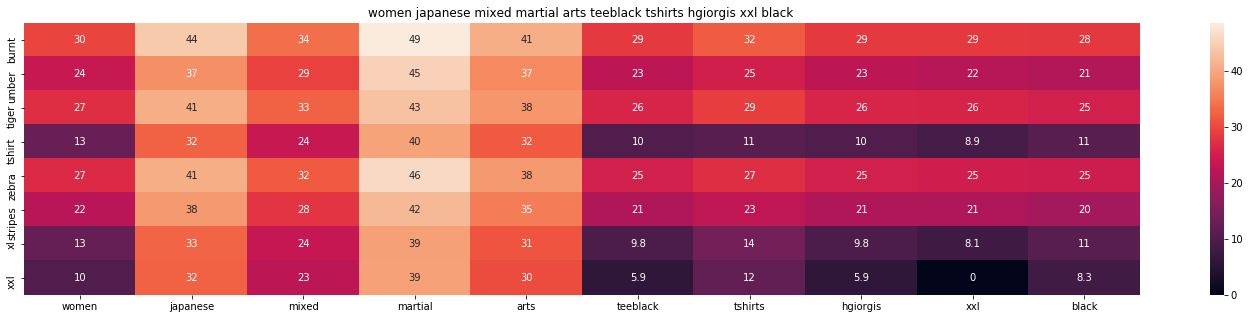

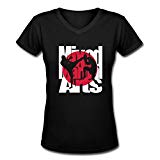

ASIN : B01JQ096HW
Brand : Constanza
euclidean distance from total data (including image) : 35.33444060059118


In [79]:
idf_w2v_brand(12566, 5, 5, 25, 20)

**This model didnt do well (as for my observation) as lot of shirts are not found to be co-related to the main shirt.**

**let us do analysis for one more shirt and stop as the file gets lenthy.**

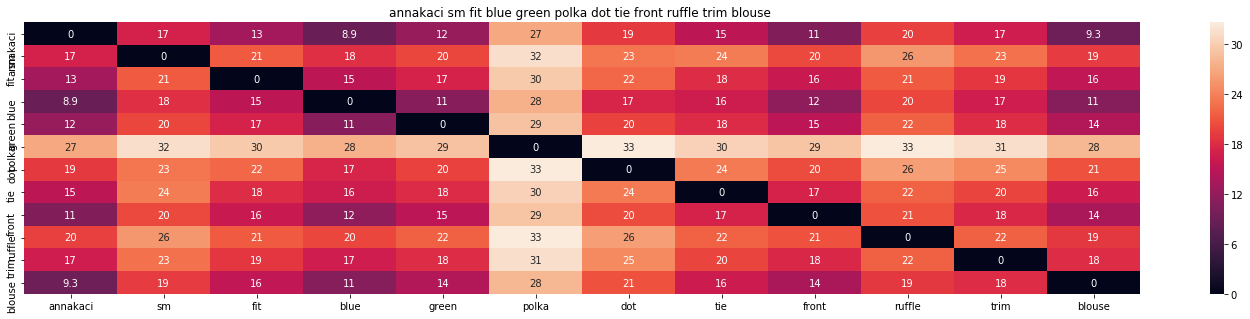

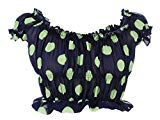

ASIN : B00KLHUIBS
Brand : Anna-Kaci
euclidean distance from total data (including image) : 1.5573436636865759e-06


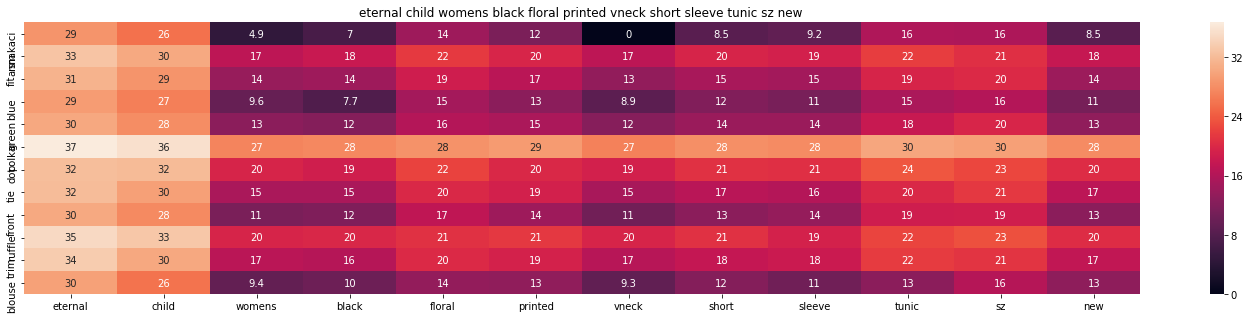

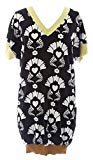

ASIN : B0184RPZNM
Brand : Eternal Child
euclidean distance from total data (including image) : 17.20011996587542


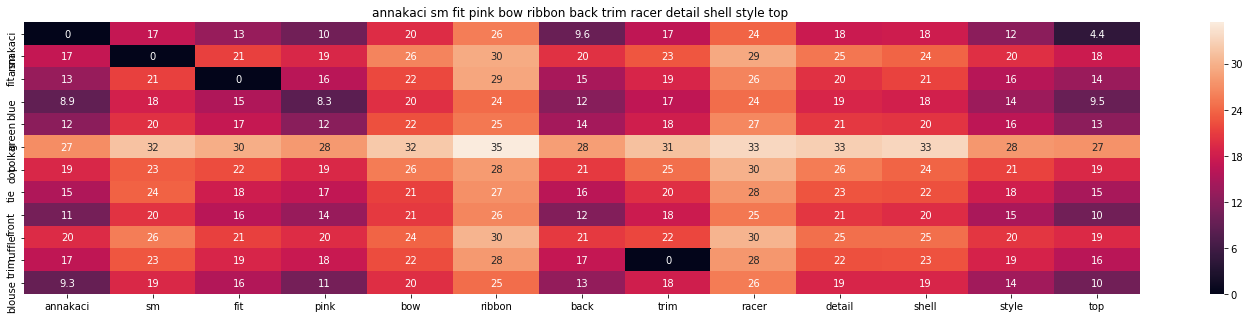

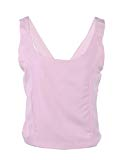

ASIN : B00KOBQEBO
Brand : Anna-Kaci
euclidean distance from total data (including image) : 17.283581044668928


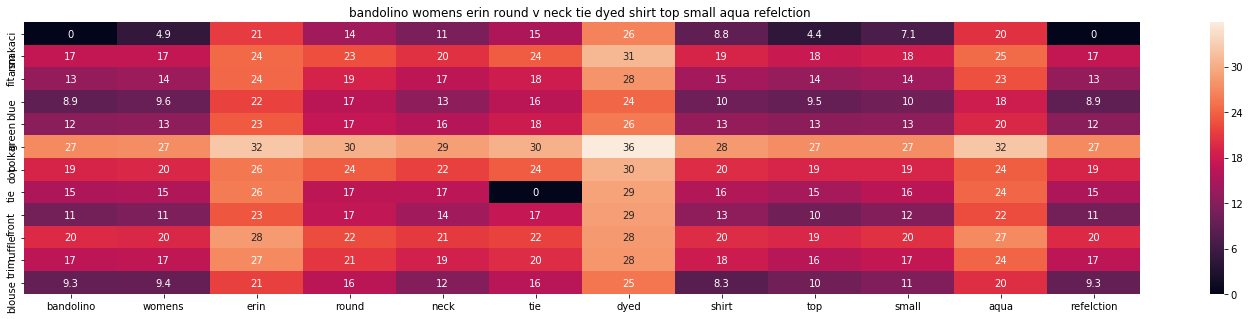

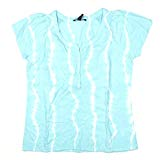

ASIN : B00ROB8A8W
Brand : Bandolino
euclidean distance from total data (including image) : 17.369906725871893


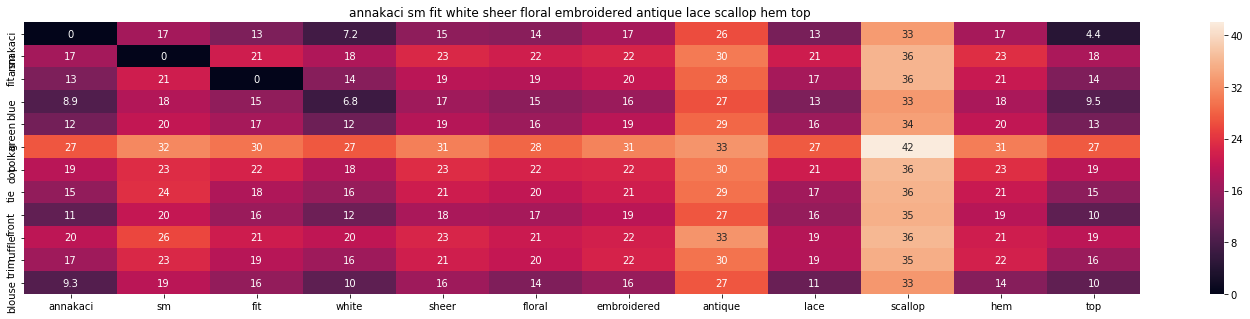

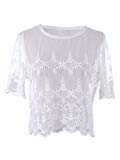

ASIN : B00L87YPVY
Brand : Anna-Kaci
euclidean distance from total data (including image) : 17.433933853683165


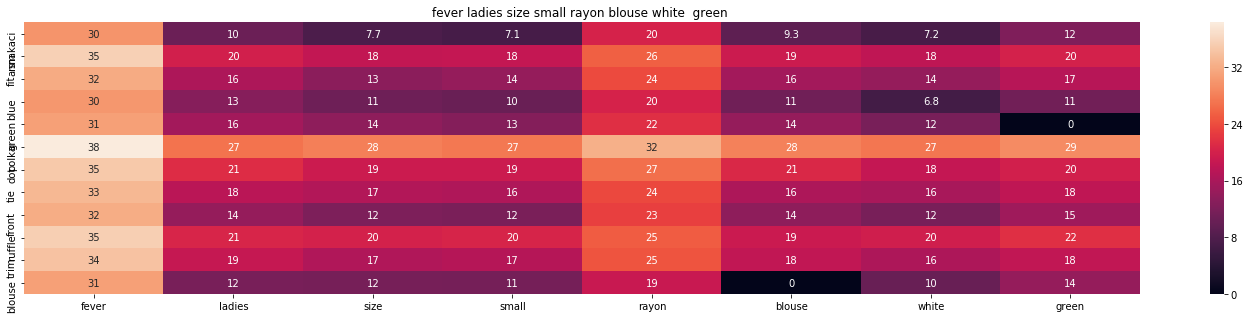

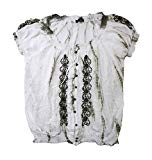

ASIN : B0731PMQZ2
Brand : Fever
euclidean distance from total data (including image) : 17.457954237725403


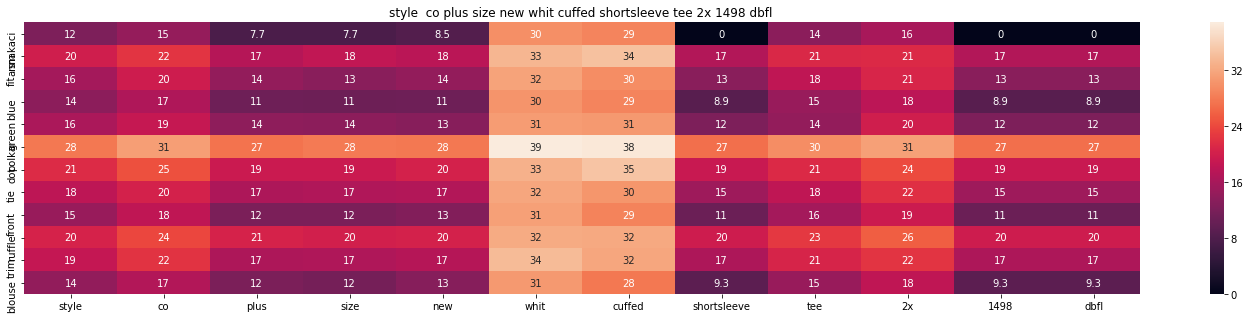

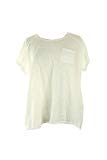

ASIN : B0178WOJVS
Brand : Styleco
euclidean distance from total data (including image) : 17.46974721771374


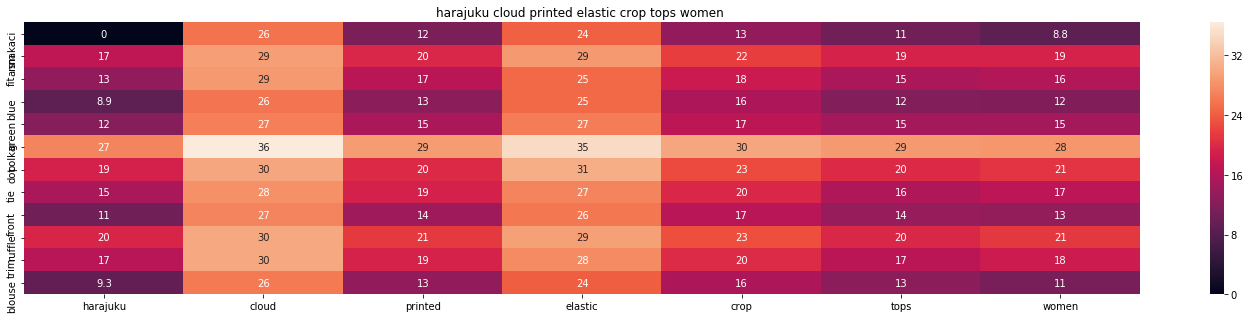

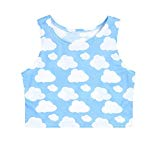

ASIN : B01KQHFVP0
Brand : namnoishop Crop Tops
euclidean distance from total data (including image) : 17.52429944221097


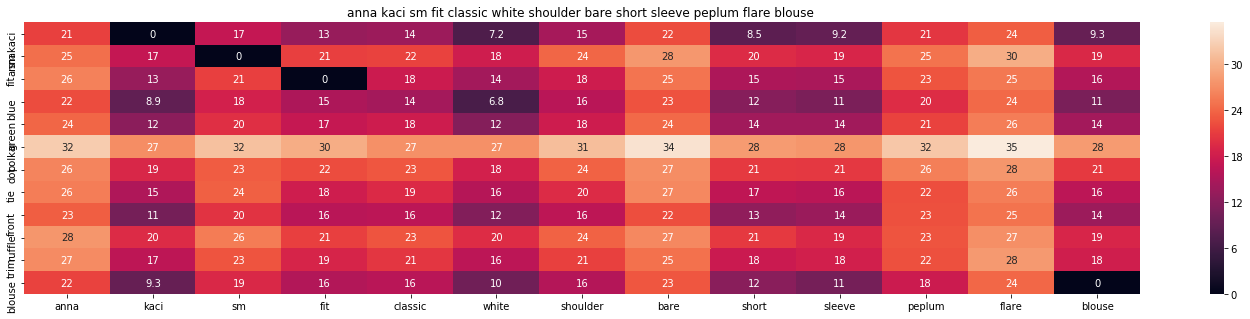

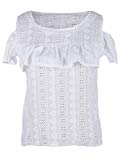

ASIN : B010EH3B8Q
Brand : Anna-Kaci
euclidean distance from total data (including image) : 17.530900492194565


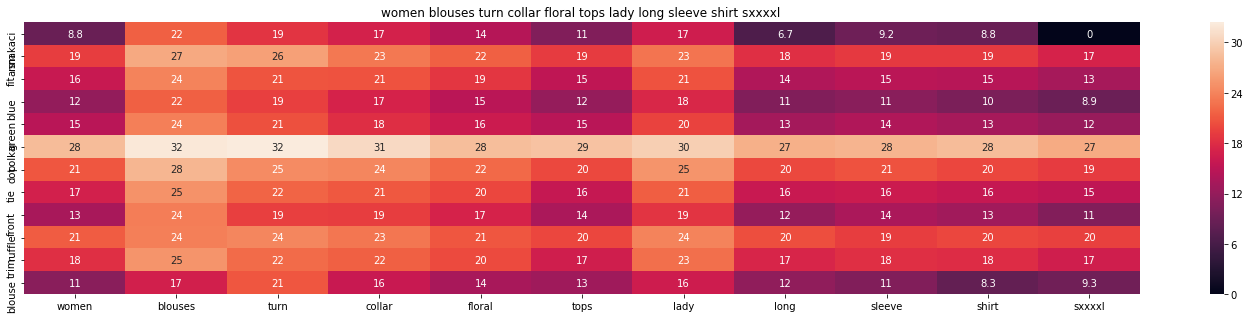

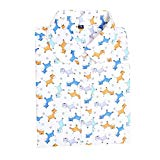

ASIN : B07552VG9B
Brand : Rbwinner
euclidean distance from total data (including image) : 17.56089272412314


In [80]:
idf_w2v_brand(931, 5, 5, 5, 10)

**The results for above example seems to be coming from different key words in the main products title like blouse and trim and some are recommended as they are same brand and remaining from image.**

## Conclusion

In [109]:
print(idf_w2v_titles.mean(), idf_w2v_titles.std())
print(extra_features.mean())
print(ordered_image_vect.mean(), ordered_image_vect.std())

-0.003048514262176509 0.07358349419808108
0.0007208518789007103
0.16385852 0.56540596


In [83]:
print(idf_w2v_titles.shape)
print(extra_features.shape)
print(ordered_image_vect.shape)

(16042, 300)
(16042, 5735)
(16042, 25088)


- **I think most of the recommendations are due to the image feature similarities (even with equal weights) as our image features dimensions is high compared to dimensions of other features. Due to this most portion of the distance is taken from image and the values are already amplified even if you give same weights due to thier high dimentions. As you can see from above code 25088 dimensions are from image features and 6035 are from title and other features.**
- **This may lead to not-so-satisfactory results and previous models where image is not considered did well (as for my observations).**